# Implementing the Transformer

This notebook is based on the Medium article https://medium.com/@bavalpreetsinghh/transformer-from-scratch-using-pytorch-28a5d1b2e033

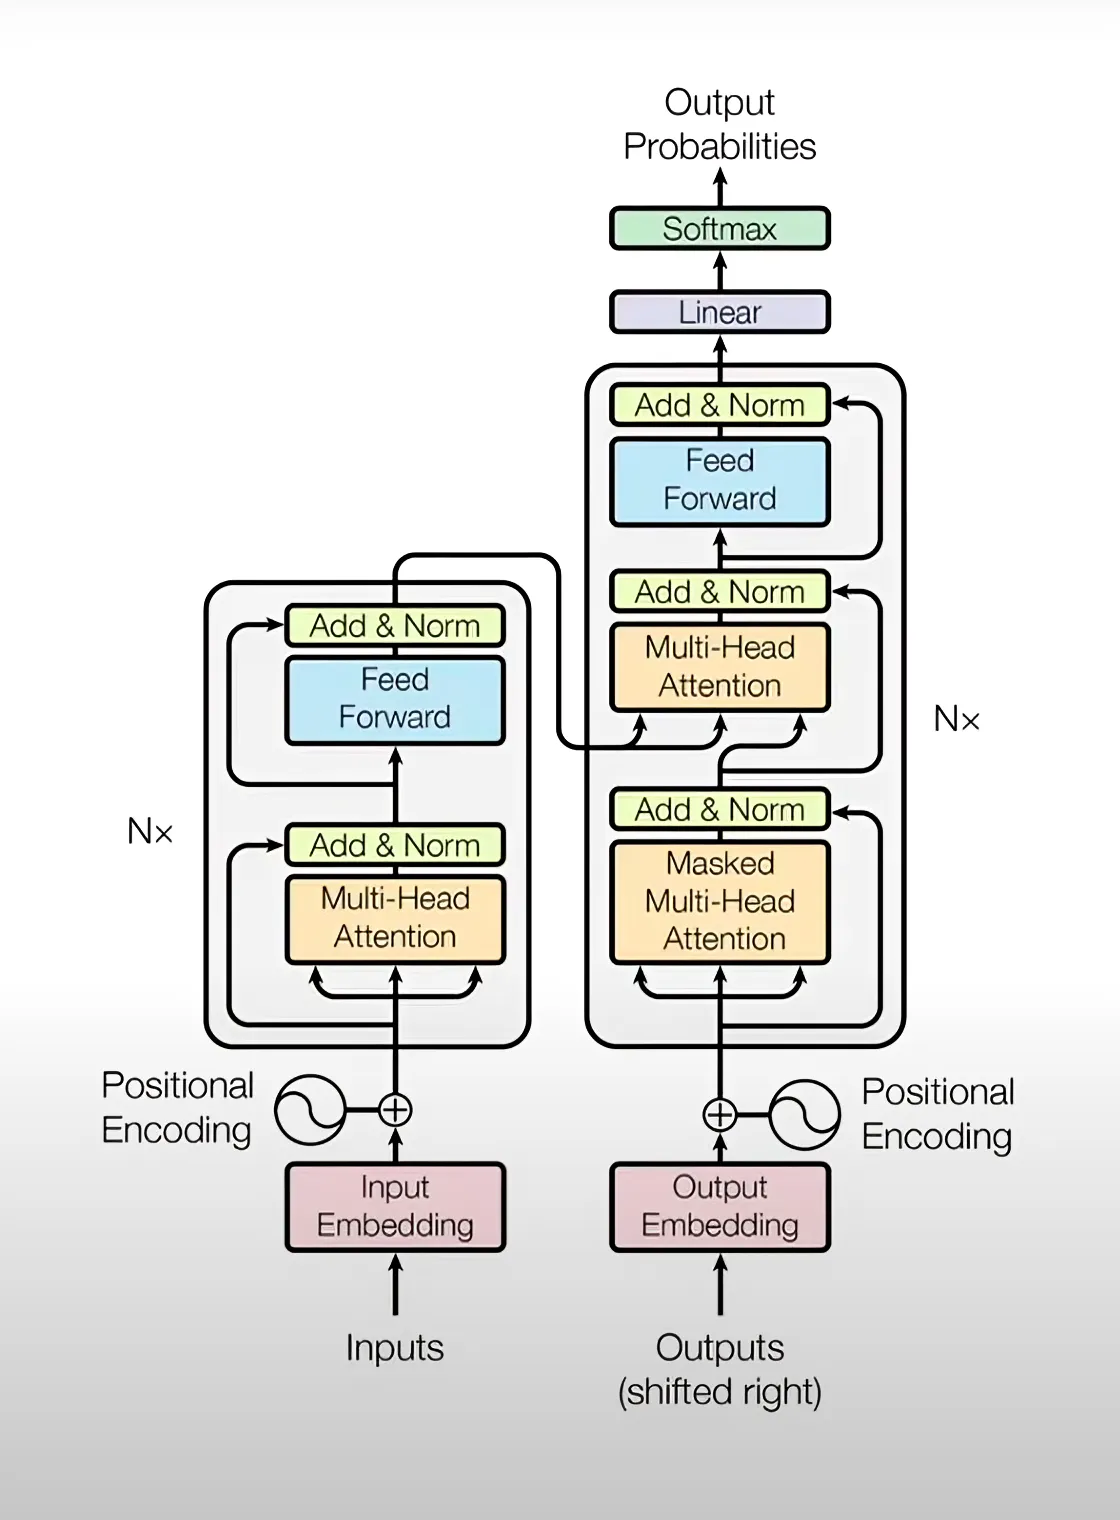

In [15]:
###########
# Imports #
###########
import torch
import torch.nn as nn
import math

## Input embeddings

The embedding layer maps indices (representing words) to a d_model-dimensional vector. This layer is initialized randomly and its vectors are learned during training

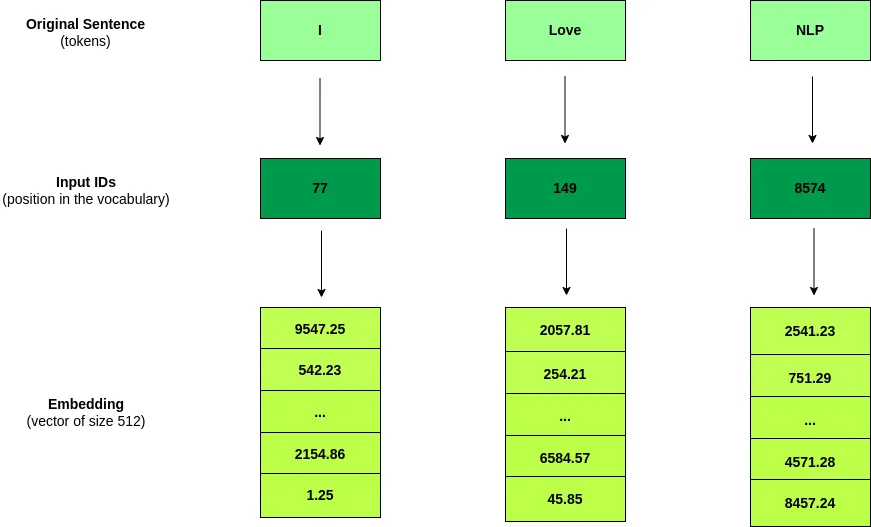

In [16]:
class InputEmbeddings(nn.Module):
    def __init__(self, d_model: int, vocab_size: int) -> None:
        super().__init__()
        self.d_model = d_model
        self.vocab_size = vocab_size

        self.embedding = nn.Embedding(vocab_size, d_model)

    def forward(self, x):
        """
        (batch, seq_len) --> (batch, seq_len, d_model)
        Multiply by sqrt(d_model) to scale the embeddings according to the paper
        """
        return self.embedding(x) * math.sqrt(self.d_model)

## Positional Encoding

To incorporate the order of tokens into their representation, we use positional encoding. Positional encodings are a function of word index and are fixed from the start

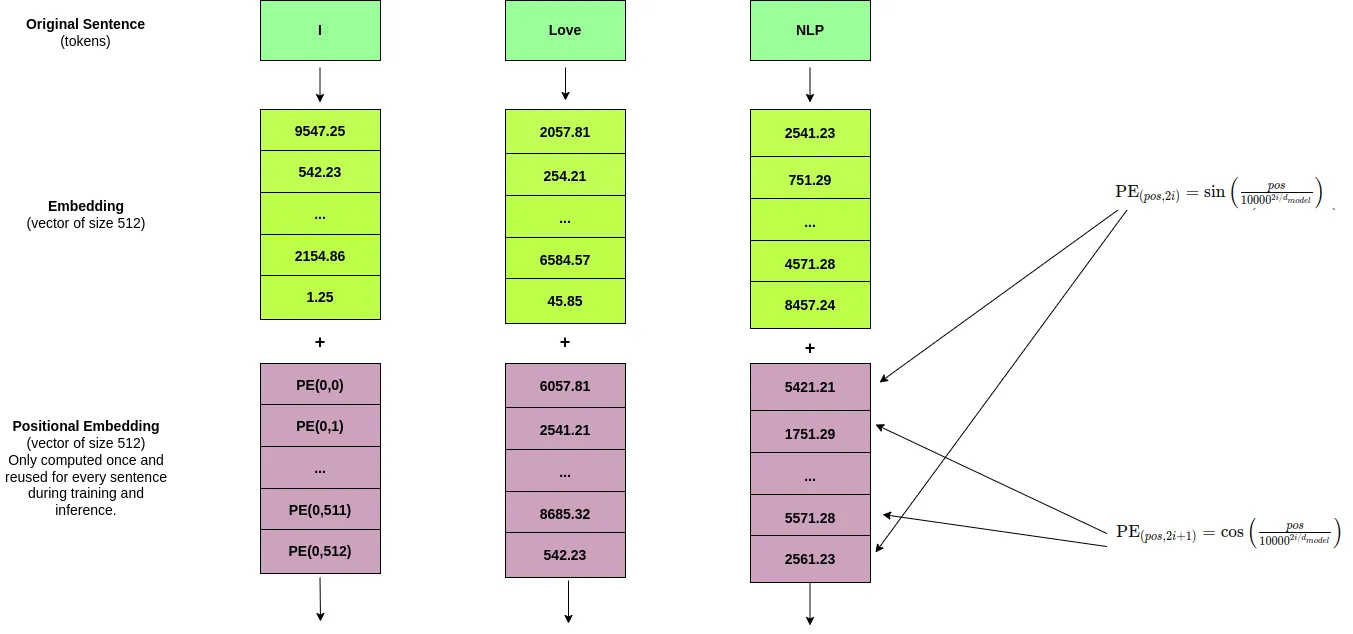

In [17]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, seq_len: int, dropout: float) -> None:
        super().__init__()
        self.d_model = d_model
        self.seq_len = seq_len
        self.dropout = nn.Dropout(dropout)

        pe = torch.zeros((seq_len, d_model))
        position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).to(torch.float32) * (-math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + (self.pe[:, :x.shape[1], :]).requires_grad_(False) # Add positional encodings to x
        return self.dropout(x)


## Layer Normalization

We normalize the inputs across the features for each training example. The input of LayerNorm will be a tensor with shape (<total_batches>, <sentence_length>, <embedding_size>) - we normalize across each word embedding by

- Computing the mean and variance across its features
- Normalize the embedding by subtracting the mean and dividing by the standard deviation

$\gamma$ and $\beta$ are learnable parameters which, respectively, scale and shift the normalized data

In [18]:
class LayerNormalization(nn.Module):
    def __init__(self, features: int, eps:float=10**-6):
        super().__init__()
        self.eps = eps # To avoid dividing by zero when std is very small
        self.gamma = nn.Parameter(torch.ones(features))
        self.beta = nn.Parameter(torch.zeros(features))
    
    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        std = x.std(dim=-1, keepdim=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta

## Feed Forward

A fully connected layer

In [19]:
class FeedForwardBlock(nn.Module):
    def __init__(self, d_model: int, d_ff: int, dropout: float) -> None:
        super().__init__()
        self.linear_1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        """(batch, seq_len, d_model) --> (batch, seq_len, d_ff) --> (batch, seq_len, d_model)"""
        return self.linear_2(self.dropout(torch.relu(self.linear_1(x))))

## Attention

### Self-Attention

We get as input a series of input vectors $X=[x_1,x_2,...,x_n]$. For each input vector $x_i$, we compute the vectors Q (query), K (key) and V (value) as linear transformations with learned weight matrices

$$Q = XW_Q; K = XW_K; V = XW_V$$

From these matrices, we compute the attention scores, which determine how much focus each position should place on other positions

$$Attention(Q, K, V) = softmax(\frac{QK^T}{\sqrt{d_K}})V$$

### Multi-Head Attention

Self-attention is extended by performing $h$ attention functions (heads) in parallel

$$Q_i = XW_i^Q; K = XW_i^K; V = XW_i^V; i = 1,2,...,h$$

$$head_i = Attention(Q_i, K_i, V_i)$$

We then concatenate the outputs of the attention heads. Here, $W^O$ is a learned weight matrix responsible for projecting the concatenated outputs back to the desired dimension

$$MultiHead(Q, K, V) = Concat(head_1, head_2, ..., head_h)W^O$$

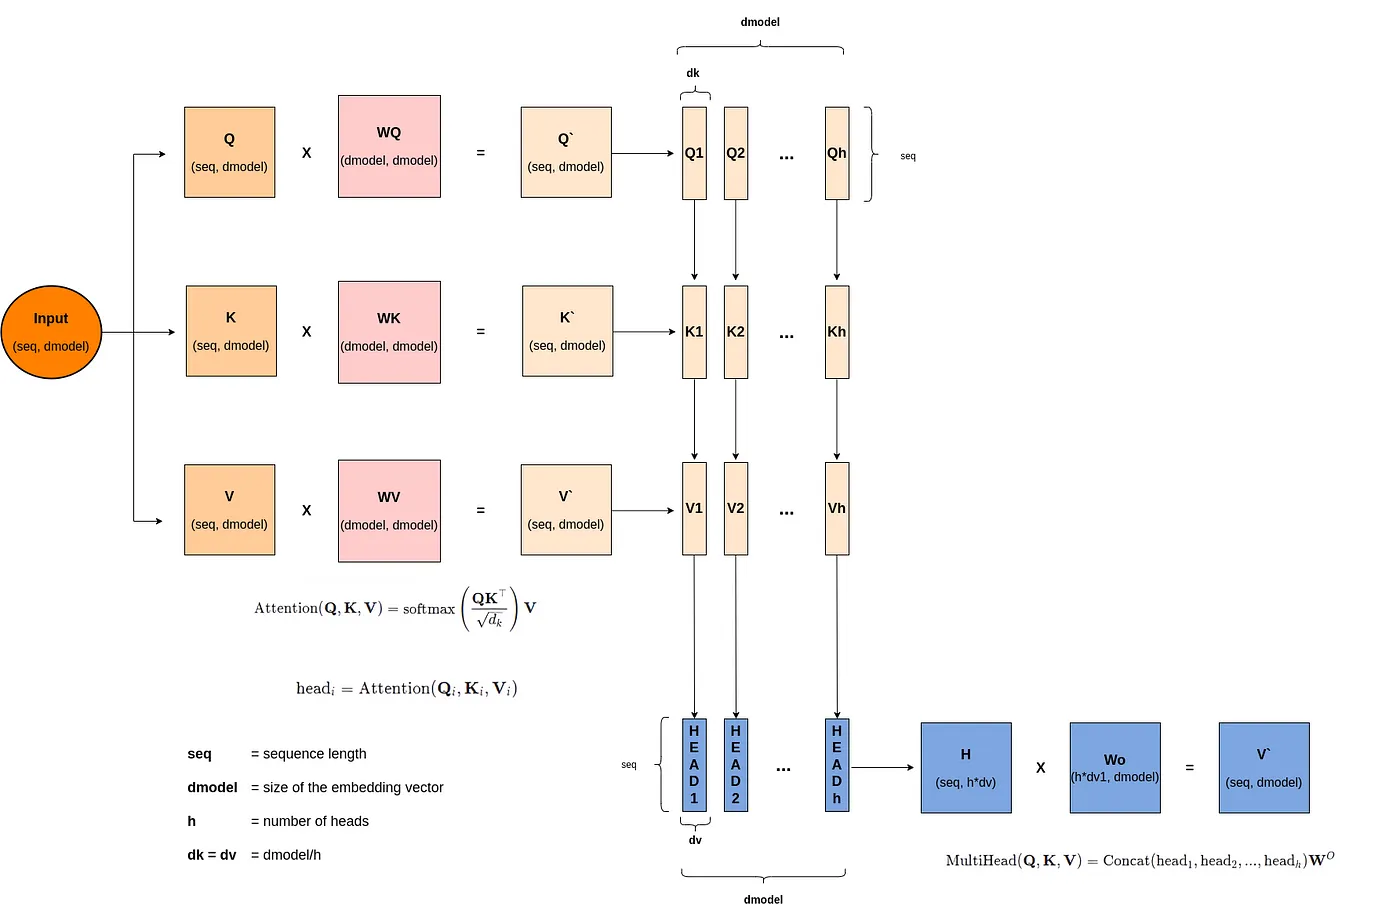

In [20]:
class MultiHeadAttentionBlock(nn.Module):
    def __init__(self, d_model: int, h: int, dropout: float) -> None:
        super().__init__()
        self.d_model = d_model
        self.h = h
        assert d_model % h == 0, f"d_model {d_model} is not divisible by h {h}"

        self.d_k = d_model // h # Dimension of vector seen by each head
        self.w_q = nn.Linear(d_model, d_model, bias=False) # Wq
        self.w_k = nn.Linear(d_model, d_model, bias=False) # Wk
        self.w_v = nn.Linear(d_model, d_model, bias=False) # Wv
        self.w_o = nn.Linear(d_model, d_model, bias=False) # Wo
        self.dropout = nn.Dropout(dropout)
        
    @staticmethod
    def attention(query, key, value, mask, dropout: nn.Dropout):
        d_k = query.shape[-1]
        attention_scores = (query @ key.transpose(-2, -1)) / math.sqrt(d_k) # @ is the matmul operator
        
        if not mask is None: # -inf where mask == 0
            attention_scores.masked_fill_(mask == 0, -1e9)
        
        attention_scores = attention_scores.softmax(dim=-1)

        if not dropout is None:
            attention_scores = dropout(attention_scores)
        
        return (attention_scores @ value), attention_scores

    def forward(self, q, k, v, mask):
        # (batch, seq_len, d_model) --> (batch, seq_len, d_model)
        query = self.w_q(q)
        key = self.w_k(k)
        value = self.w_v(v)

        # (batch, seq_len, d_model) --> (batch, seq_len, h, d_k) --> (batch, h, seq_len, d_k)
        query = query.view(query.shape[0], query.shape[1], self.h, self.d_k).transpose(1, 2)
        key = key.view(key.shape[0], key.shape[1], self.h, self.d_k).transpose(1, 2)
        value = value.view(value.shape[0], value.shape[1], self.h, self.d_k).transpose(1, 2)

        x, self.attention_scores = MultiHeadAttentionBlock.attention(query, key, value, mask, self.dropout)
        
        # (batch, h, seq_len, d_k) --> (batch, seq_len, h, d_k) --> (batch, seq_len, d_model)
        x = x.transpose(1, 2).contiguous().view(x.shape[0], -1, self.h * self.d_k)
        return self.w_o(x)



## Residual Connections

Used to "skip" one or more layers in a network, connecting the input of a layer to the output of another

In [21]:
class ResidualConnection(nn.Module):
    def __init__(self, dropout: float) -> None:
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.norm = LayerNormalization()
    
    def forward(self, x, sublayer):
        return x + self.dropout(sublayer(self.norm(x)))

## Encoder

Our encoder will contain one multi-head attention, two Add and Norm and one feed forward layer

In [22]:
class EncoderBlock(nn.Module):
    def __init__(self, self_attention_block: MultiHeadAttentionBlock, feed_forward_block: FeedForwardBlock, dropout: float) -> None:
        super().__init__()
        self.self_attention_block = self_attention_block
        self.feed_forward_network = feed_forward_block
        self.residual_connections = nn.ModuleList([ResidualConnection(dropout) for _ in range(2)])
    
    def forward(self, x, src_mask):
        x = self.residual_connections[0](x, lambda x: self.self_attention_block(x, x, x, src_mask))
        x = self.residual_connections[1](x, self.feed_forward_network)
        return x


class Encoder(nn.Module):
    def __init__(self, layers: nn.ModuleList) -> None:
        super().__init__()
        self.layers = layers
        self.norm = LayerNormalization()
    
    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

## Decoder

Our decoder is composed of a series of blocks that each contain a self-attention mechanism, a cross-attention mechanism, and a feed-forward network

In [23]:
class DecoderBlock(nn.Module):
    def __init__(self, self_attention_block: MultiHeadAttentionBlock, cross_attention_block: MultiHeadAttentionBlock, feed_forward_block: FeedForwardBlock, dropout:float)->None:
        super().__init__()
        self.self_attention_block = self_attention_block
        self.cross_attention_block = cross_attention_block
        self.feed_forward_block = feed_forward_block
        self.residual_connections = nn.ModuleList([ResidualConnection(dropout) for _ in range(3)])

    def forward(self, x, encoder_output, src_mask, tgt_mask):
        x = self.residual_connections[0](x, lambda x: self.self_attention_block(x,x,x,tgt_mask))
        x = self.residual_connections[1](x, lambda x: self.cross_attention_block(x, encoder_output, encoder_output, src_mask))
        x = self.residual_connections[2](x, self.feed_forward_block)
        return x


class Decoder(nn.Module):
    def __init__(self, features: int, layers: nn.ModuleList) -> None:
        super().__init__()
        self.layers = layers
        self.norm = LayerNormalization(features)

    def forward(self, x, encoder_output, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, encoder_output, src_mask, tgt_mask)
        return self.norm(x)

## Projection Layer

Converts the high-dimensional output of the decoder into logits over the vocabulary

In [24]:
class ProjectionLayer(nn.Module):

    def __init__(self, d_model, vocab_size) -> None:
        super().__init__()
        self.proj = nn.Linear(d_model, vocab_size)

    def forward(self, x) -> None:
        # (batch, seq_len, d_model) --> (batch, seq_len, vocab_size)
        return self.proj(x)

## Transformer

We built the final model

In [25]:
class Transformer(nn.Module):

    def __init__(self, encoder: Encoder, decoder: Decoder, src_embed: InputEmbeddings, tgt_embed: InputEmbeddings, src_pos: PositionalEncoding, tgt_pos: PositionalEncoding, projection_layer: ProjectionLayer) -> None:
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.src_pos = src_pos
        self.tgt_pos = tgt_pos
        self.projection_layer = projection_layer

    def encode(self, src, src_mask):
        # (batch, seq_len, d_model)
        src = self.src_embed(src)
        src = self.src_pos(src)
        return self.encoder(src, src_mask)
    
    def decode(self, encoder_output: torch.Tensor, src_mask: torch.Tensor, tgt: torch.Tensor, tgt_mask: torch.Tensor):
        # (batch, seq_len, d_model)
        tgt = self.tgt_embed(tgt)
        tgt = self.tgt_pos(tgt)
        return self.decoder(tgt, encoder_output, src_mask, tgt_mask)
    
    def project(self, x):
        # (batch, seq_len, vocab_size)
        return self.projection_layer(x)


def build_transformer(src_vocab_size: int, tgt_vocab_size: int, src_seq_len: int, tgt_seq_len: int, d_model: int=512, N: int=6, h: int=8, dropout: float=0.1, d_ff: int=2048) -> Transformer:
    # Create the embedding layers
    src_embed = InputEmbeddings(d_model, src_vocab_size)
    tgt_embed = InputEmbeddings(d_model, tgt_vocab_size)

    # Create the positional encoding layers
    src_pos = PositionalEncoding(d_model, src_seq_len, dropout)
    tgt_pos = PositionalEncoding(d_model, tgt_seq_len, dropout)
    
    # Create the encoder blocks
    encoder_blocks = []
    for _ in range(N):
        encoder_self_attention_block = MultiHeadAttentionBlock(d_model, h, dropout)
        feed_forward_block = FeedForwardBlock(d_model, d_ff, dropout)
        encoder_block = EncoderBlock(d_model, encoder_self_attention_block, feed_forward_block, dropout)
        encoder_blocks.append(encoder_block)

    # Create the decoder blocks
    decoder_blocks = []
    for _ in range(N):
        decoder_self_attention_block = MultiHeadAttentionBlock(d_model, h, dropout)
        decoder_cross_attention_block = MultiHeadAttentionBlock(d_model, h, dropout)
        feed_forward_block = FeedForwardBlock(d_model, d_ff, dropout)
        decoder_block = DecoderBlock(d_model, decoder_self_attention_block, decoder_cross_attention_block, feed_forward_block, dropout)
        decoder_blocks.append(decoder_block)
    
    # Create the encoder and decoder
    encoder = Encoder(d_model, nn.ModuleList(encoder_blocks))
    decoder = Decoder(d_model, nn.ModuleList(decoder_blocks))
    
    # Create the projection layer
    projection_layer = ProjectionLayer(d_model, tgt_vocab_size)
    
    # Create the transformer
    transformer = Transformer(encoder, decoder, src_embed, tgt_embed, src_pos, tgt_pos, projection_layer)
    
    # Initialize the parameters
    for p in transformer.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    
    return transformer

## Datasets

We get the datasets for training our Transformer

From here, we follow https://plainenglish.io/blog/building-and-training-a-transformer-from-scratch

In [26]:
# Torch
from torch.utils.data import Dataset, DataLoader, random_split

# HuggingFace libraries
from datasets import load_dataset
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.trainers import WordLevelTrainer
from tokenizers.pre_tokenizers import Whitespace

# Pathlib
from pathlib import Path

# typing
from typing import  Any

# Library for progress bars in loops
from tqdm import tqdm

# Importing library of warnings
import warnings


class  BilingualDataset(Dataset):
    # This takes in the dataset contaning sentence pairs, the tokenizers for target and source languages, and the strings of source and target languages
    # 'seq_len' defines the sequence length for both languages
    def  __init__(self, ds, tokenizer_src, tokenizer_tgt, src_lang, tgt_lang, seq_len) -> None:
        super().__init__()

        self.seq_len = seq_len
        self.ds = ds
        self.tokenizer_src = tokenizer_src
        self.tokenizer_tgt = tokenizer_tgt
        self.src_lang = src_lang
        self.tgt_lang = tgt_lang

        # Defining special tokens by using the target language tokenizer
        self.sos_token = torch.tensor([tokenizer_tgt.token_to_id("[SOS]")], dtype=torch.int64)
        self.eos_token = torch.tensor([tokenizer_tgt.token_to_id("[EOS]")], dtype=torch.int64)
        self.pad_token = torch.tensor([tokenizer_tgt.token_to_id("[PAD]")], dtype=torch.int64)

    # Total number of instances in the dataset (some pairs are larger than others)
    def  __len__(self):
        return  len(self.ds)

    # Using the index to retrive source and target texts
    def  __getitem__(self, index: Any) -> Any:
        src_target_pair = self.ds[index]
        src_text = src_target_pair['translation'][self.src_lang]
        tgt_text = src_target_pair['translation'][self.tgt_lang]

        # Tokenizing source and target texts
        enc_input_tokens = self.tokenizer_src.encode(src_text).ids
        dec_input_tokens = self.tokenizer_tgt.encode(tgt_text).ids

        enc_num_padding_tokens = self.seq_len - len(enc_input_tokens) - 2  # Subtracting the two '[EOS]' and '[SOS]' special tokens
        dec_num_padding_tokens = self.seq_len - len(dec_input_tokens) - 1  # Subtracting the '[SOS]' special token

        if enc_num_padding_tokens < 0  or dec_num_padding_tokens < 0:
            raise ValueError('Sentence is too long')

        encoder_input = torch.cat(
        [
        self.sos_token, # inserting the '[SOS]' token
        torch.tensor(enc_input_tokens, dtype = torch.int64), # Inserting the tokenized source text
        self.eos_token, # Inserting the '[EOS]' token
        torch.tensor([self.pad_token] * enc_num_padding_tokens, dtype = torch.int64) # Addind padding tokens
        ]
        )

        decoder_input = torch.cat(
        [
        self.sos_token, # inserting the '[SOS]' token
        torch.tensor(dec_input_tokens, dtype = torch.int64), # Inserting the tokenized target text
        torch.tensor([self.pad_token] * dec_num_padding_tokens, dtype = torch.int64) # Addind padding tokens
        ]

        )

        # Creating a label tensor, the expected output for training the model
        label = torch.cat(
        [
        torch.tensor(dec_input_tokens, dtype = torch.int64), # Inserting the tokenized target text
        self.eos_token, # Inserting the '[EOS]' token
        torch.tensor([self.pad_token] * dec_num_padding_tokens, dtype = torch.int64) # Adding padding tokens

        ]
        )

        # Ensuring that the length of each tensor above is equal to the defined 'seq_len'
        assert encoder_input.size(0) == self.seq_len
        assert decoder_input.size(0) == self.seq_len
        assert label.size(0) == self.seq_len

        return {
        'encoder_input': encoder_input,
        'decoder_input': decoder_input,
        'encoder_mask': (encoder_input != self.pad_token).unsqueeze(0).unsqueeze(0).int(),
        'decoder_mask': (decoder_input != self.pad_token).unsqueeze(0).unsqueeze(0).int() & casual_mask(decoder_input.size(0)),
        'label': label,
        'src_text': src_text,
        'tgt_text': tgt_text
        }



# Iterating through dataset to extract the original sentence and its translation
def get_all_sentences(ds, lang):
    for pair in ds:
        yield pair['translation'][lang]

def build_tokenizer(config, ds, lang):
    tokenizer_path = Path(config['tokenizer_file'].format(lang))

    if  not Path.exists(tokenizer_path):
        tokenizer = Tokenizer(WordLevel(unk_token = '[UNK]')) 
        tokenizer.pre_tokenizer = Whitespace() 

        trainer = WordLevelTrainer(special_tokens = ["[UNK]", "[PAD]",
        "[SOS]", "[EOS]"], min_frequency = 2)

        tokenizer.train_from_iterator(get_all_sentences(ds, lang), trainer = trainer)
        tokenizer.save(str(tokenizer_path))
    else: # If the tokenizer already exist, we load it
        tokenizer = Tokenizer.from_file(str(tokenizer_path)) 

    return tokenizer 

def get_ds(config):
    ds_raw = load_dataset('opus_books', f'{config["lang_src"]}-{config["lang_tgt"]}', split = 'train')

    tokenizer_src = build_tokenizer(config, ds_raw, config['lang_src'])
    tokenizer_tgt = build_tokenizer(config, ds_raw, config['lang_tgt'])

    train_ds_size = int(0.9 * len(ds_raw)) # 90% for training
    val_ds_size = len(ds_raw) - train_ds_size # 10% for validation
    train_ds_raw, val_ds_raw = random_split(ds_raw, [train_ds_size, val_ds_size]) # Randomly splitting the dataset

    train_ds = BilingualDataset(train_ds_raw, tokenizer_src, tokenizer_tgt, config['lang_src'], config['lang_tgt'], config['seq_len'])
    val_ds = BilingualDataset(val_ds_raw, tokenizer_src, tokenizer_tgt, config['lang_src'], config['lang_tgt'], config['seq_len'])

    # Iterating over the entire dataset and printing the maximum length found in the sentences of both the source and target languages
    max_len_src = 0
    max_len_tgt = 0
    for pair in ds_raw:
        src_ids = tokenizer_src.encode(pair['translation'][config['lang_src']]).ids
        tgt_ids = tokenizer_src.encode(pair['translation'][config['lang_tgt']]).ids
        max_len_src = max(max_len_src, len(src_ids))
        max_len_tgt = max(max_len_tgt, len(tgt_ids))

    print(f'Max length of source sentence: {max_len_src}')
    print(f'Max length of target sentence: {max_len_tgt}')

    train_dataloader = DataLoader(train_ds, batch_size = config['batch_size'], shuffle = True)
    val_dataloader = DataLoader(val_ds, batch_size = 1, shuffle = True)

    return train_dataloader, val_dataloader, tokenizer_src, tokenizer_tgt 

def casual_mask(size):
    mask = torch.triu(torch.ones(1, size, size), diagonal = 1).type(torch.int)
    return mask == 0

ModuleNotFoundError: No module named 'datasets'

## Validation

In [ ]:
# Define function to obtain the most probable next token
def  greedy_decode(model, source, source_mask, tokenizer_src, tokenizer_tgt, max_len, device):
    sos_idx = tokenizer_tgt.token_to_id('[SOS]')
    eos_idx = tokenizer_tgt.token_to_id('[EOS]')

    encoder_output = model.encode(source, source_mask)
    decoder_input = torch.empty(1,1).fill_(sos_idx).type_as(source).to(device)

    # Looping until the 'max_len', maximum length, is reached
    while  True:
        if decoder_input.size(1) == max_len:
            break

        decoder_mask = casual_mask(decoder_input.size(1)).type_as(source_mask).to(device)

        out = model.decode(encoder_output, source_mask, decoder_input, decoder_mask)

        prob = model.project(out[:, -1])

        _, next_word = torch.max(prob, dim=1)
        decoder_input = torch.cat([decoder_input, torch.empty(1,1). type_as(source).fill_(next_word.item()).to(device)], dim=1)

        # If the next token is an End of Sentence token, we finish the loop
        if next_word == eos_idx:
            break

    return decoder_input.squeeze(0) # Sequence of tokens generated by the decoder

# Defining function to evaluate the model on the validation dataset
# num_examples = 2, two examples per run
def  run_validation(model, validation_ds, tokenizer_src, tokenizer_tgt, max_len, device, print_msg, global_state, writer, num_examples=2):
    model.eval() # Setting model to evaluation mode
    count = 0  # Initializing counter to keep track of how many examples have been processed

    console_width = 80  # Fixed witdh for printed messages

    # Creating evaluation loop
    with torch.no_grad(): # Ensuring that no gradients are computed during this process
        for batch in validation_ds:
            count += 1
            encoder_input = batch['encoder_input'].to(device)
            encoder_mask = batch['encoder_mask'].to(device)

            # Ensuring that the batch_size of the validation set is 1
            assert encoder_input.size(0) == 1, 'Batch size must be 1 for validation.'

            # Applying the 'greedy_decode' function to get the model's output for the source text of the input batch
            model_out = greedy_decode(model, encoder_input, encoder_mask, tokenizer_src, tokenizer_tgt, max_len, device)

            # Retrieving source and target texts from the batch
            source_text = batch['src_text'][0]
            target_text = batch['tgt_text'][0] # True translation
            model_out_text = tokenizer_tgt.decode(model_out.detach().cpu().numpy()) # Decoded, human-readable model output

            # Printing results
            print_msg('-'*console_width)
            print_msg(f'SOURCE: {source_text}')
            print_msg(f'TARGET: {target_text}')
            print_msg(f'PREDICTED: {model_out_text}')

            # After two examples, we break the loop
            if count == num_examples:
                break

## Training

In [ ]:
# We pass as parameters the config dictionary, the length of the vocabylary of the source language and the target language
def  get_model(config, vocab_src_len, vocab_tgt_len):

    # Loading model using the 'build_transformer' function.
    # We will use the lengths of the source language and target language vocabularies, the 'seq_len', and the dimensionality of the embeddings
    model = build_transformer(vocab_src_len, vocab_tgt_len, config['seq_len'], config['seq_len'], config['d_model'])
    return model

# Define settings for building and training the transformer model
def  get_config():
    return{
    'batch_size': 8,
    'num_epochs': 20,
    'lr': 10**-4,
    'seq_len': 350,
    'd_model': 512, # Dimensions of the embeddings in the Transformer. 512 like in the "Attention Is All You Need" paper.
    'lang_src': 'en',
    'lang_tgt': 'it',
    'model_folder': 'weights',
    'model_basename': 'tmodel_',
    'preload': None,
    'tokenizer_file': 'tokenizer_{0}.json',
    'experiment_name': 'runs/tmodel'
    }

# Function to construct the path for saving and retrieving model weights
def  get_weights_file_path(config, epoch: str):
    model_folder = config['model_folder'] # Extracting model folder from the config
    model_basename = config['model_basename'] # Extracting the base name for model files
    model_filename = f"{model_basename}{epoch}.pt"  # Building filename
    return  str(Path('.')/ model_folder/ model_filename) # Combining current directory, the model folder, and the model filename

def  train_model(config):
    # Setting up device to run on GPU to train faster
    device = torch.device('cuda'  if torch.cuda.is_available() else  'cpu')
    print(f"Using device {device}")

    # Creating model directory to store weights
    Path(config['model_folder']).mkdir(parents=True, exist_ok=True)

    # Retrieving dataloaders and tokenizers for source and target languages using the 'get_ds' function
    train_dataloader, val_dataloader, tokenizer_src, tokenizer_tgt = get_ds(config)

    # Initializing model on the GPU using the 'get_model' function
    model = get_model(config,tokenizer_src.get_vocab_size(), tokenizer_tgt.get_vocab_size()).to(device)

    # Setting up the Adam optimizer with the specified learning rate from the '
    # config' dictionary plus an epsilon value
    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'], eps = 1e-9)

    # Initializing epoch and global step variables
    initial_epoch = 0
    global_step = 0

    # Checking if there is a pre-trained model to load
    # If true, loads it
    if config['preload']:
        model_filename = get_weights_file_path(config, config['preload'])
        print(f'Preloading model {model_filename}')
        state = torch.load(model_filename) # Loading model

    # Sets epoch to the saved in the state plus one, to resume from where it stopped
    initial_epoch = state['epoch'] + 1
    # Loading the optimizer state from the saved model
    optimizer.load_state_dict(state['optimizer_state_dict'])
    # Loading the global step state from the saved model
    global_step = state['global_step']

    # Initializing CrossEntropyLoss function for training
    # We ignore padding tokens when computing loss, as they are not relevant for the learning process
    # We also apply label_smoothing to prevent overfitting
    loss_fn = nn.CrossEntropyLoss(ignore_index = tokenizer_src.token_to_id('[PAD]'), label_smoothing = 0.1).to(device)

    # Initializing training loop

    # Iterating over each epoch from the 'initial_epoch' variable up to
    # the number of epochs informed in the config
    for epoch in  range(initial_epoch, config['num_epochs']):

        # Initializing an iterator over the training dataloader
        # We also use tqdm to display a progress bar
        batch_iterator = tqdm(train_dataloader, desc = f'Processing epoch {epoch:02d}')

        # For each batch...
        for batch in batch_iterator:
            model.train() # Train the model

            # Loading input data and masks onto the GPU
            encoder_input = batch['encoder_input'].to(device)
            decoder_input = batch['decoder_input'].to(device)
            encoder_mask = batch['encoder_mask'].to(device)
            decoder_mask = batch['decoder_mask'].to(device)

            # Running tensors through the Transformer
            encoder_output = model.encode(encoder_input, encoder_mask)
            decoder_output = model.decode(encoder_output, encoder_mask, decoder_input, decoder_mask)
            proj_output = model.project(decoder_output)

            # Loading the target labels onto the GPU
            label = batch['label'].to(device)

            # Computing loss between model's output and true labels
            loss = loss_fn(proj_output.view(-1, tokenizer_tgt.get_vocab_size()), label.view(-1))

            # Updating progress bar
            batch_iterator.set_postfix({f"loss": f"{loss.item():6.3f}"})

            writer.add_scalar('train loss', loss.item(), global_step)
            writer.flush()

            # Performing backpropagation
            loss.backward()

            # Updating parameters based on the gradients
            optimizer.step()

            # Clearing the gradients to prepare for the next batch
            optimizer.zero_grad()

            global_step += 1  # Updating global step count

        # We run the 'run_validation' function at the end of each epoch
        # to evaluate model performance
        run_validation(model, val_dataloader, tokenizer_src, tokenizer_tgt, config['seq_len'], device, lambda msg: batch_iterator.write(msg), global_step, writer)

    # Saving model
    model_filename = get_weights_file_path(config, f'{epoch:02d}')
    # Writting current model state to the 'model_filename'
    torch.save({
    'epoch': epoch, # Current epoch
    'model_state_dict': model.state_dict(),# Current model state
    'optimizer_state_dict': optimizer.state_dict(), # Current optimizer state
    'global_step': global_step # Current global step
    }, model_filename)

In [ ]:
warnings.filterwarnings('ignore') # Filtering warnings
config = get_config() # Retrieving config settings
train_model(config) # Training model with the config arguments